In [1]:
# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('./marketdata/soybean/zsn20_daily_price-history-10-25-2019.csv')
#dataset_train = dataset_train[dataset_train["Volume"] != 0]

dataset_train.Time = pd.to_datetime(dataset_train.Time.str.replace('D', 'T'))
dataset_train = dataset_train.sort_values('Time')
dataset_train.set_index('Time', inplace=True)
print(dataset_train.shape)
ax = dataset_train["Last"].plot(figsize=(14, 7))
ax.axvline("26-04-2019", linestyle="--", c="black")
ax.axvline("08-09-2019", linestyle="--", c="black")

(742, 7)


In [2]:
df_train = dataset_train[dataset_train.index < "26-04-2019"]
df_train.shape

(614, 7)

In [3]:
df_val = dataset_train[(dataset_train.index >= "26-04-2019") & (dataset_train.index < "08-09-2019")]
df_val.shape

(73, 7)

In [4]:
training_set = dataset_train.iloc[:, 1:8].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
# Creating a data structure with 15 timesteps and 1 output - we use last 15 prices to predict next. 
#This takes data from 15th row onwards
X_whole = []
y_whole = []
sequence_size = 1
for i in range(sequence_size, len(training_set_scaled)):
    X_whole = np.append(X_whole, training_set_scaled[i-sequence_size:i, 2])
    #X_whole = np.append(X_whole, training_set_scaled[i, 6])
    #X_whole = np.append(X_whole, training_set_scaled[i, 7])
    vwap = 0
    vol = 0
    vchg = 0
    for j in range(sequence_size):
        if (j+i<training_set_scaled.shape[0]):
            vwap += (((np.sum(training_set_scaled[j+i, 0:3]))/3) * training_set_scaled[j+i, 4])
            vchg += (((training_set_scaled[j+i, 3])) * training_set_scaled[j+i, 4])
            vol += training_set_scaled[j+i, 4]
    #if vwap !=0  and vol != 0:
    X_whole = np.append(X_whole, vwap/vol)
    X_whole = np.append(X_whole, vchg/vol)
    y_whole.append(training_set_scaled[i, 2])

sz = training_set_scaled.shape[0]-sequence_size
X_whole, y_whole = np.array(X_whole.reshape(sz,sequence_size+2)), np.array(y_whole)

In [6]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

In [7]:
%%time
# Part 2 - Building the RNN

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
#X_whole = np.reshape(X_whole, (X_whole.shape[0], X_whole.shape[1], 1))

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compiling the RNN
regressor.compile(optimizer = adm, loss = 'mean_squared_error' , metrics=["mean_squared_error"])

# Fitting the RNN to the Training set #, validation_data=(X_valid, y_valid)
hist = regressor.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs = 400, batch_size = 8, verbose=0)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Wall time: 2min


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


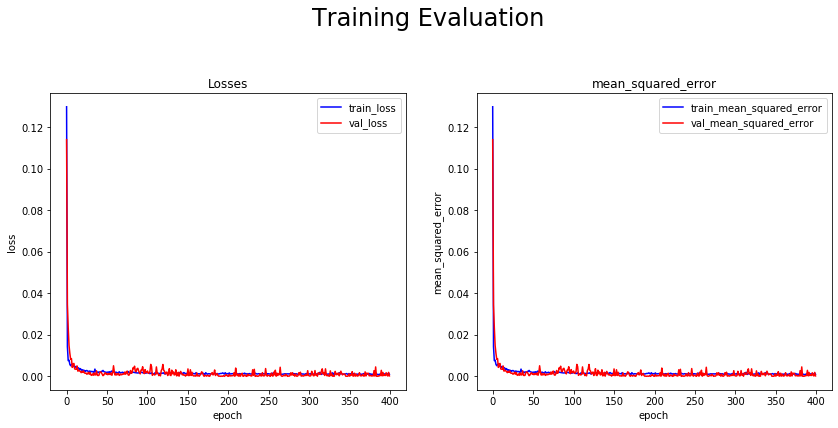

In [8]:
#regressor.save_weights("zns20_400epoch_Rsqr98.h5")
#print("Saved model to disk")
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [9]:
#create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(y_test), 6) )
test_data[:,2] = y_test
real_stock_price = sc.inverse_transform(test_data)[:,2]
#real_stock_price

sqrt mean_squared_error:  1.4806388546214613
mean_squared_error:  2.192291417814753
mean_absolute_error:  1.1755736198427125
R Squared: 0.996564587836493 
Adjusted R Squared: 0.9965320760494567


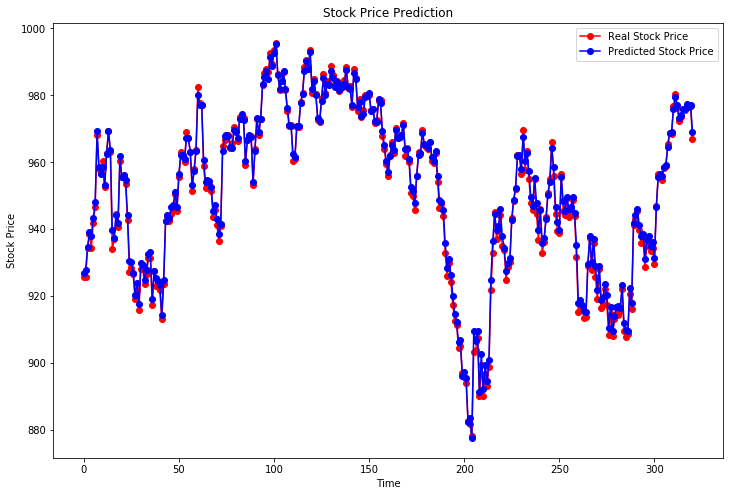

In [10]:
# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
# create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(predicted_stock_price), 6) )
test_data[:,2] = predicted_stock_price.reshape(1,-1)
predicted_stock_price = sc.inverse_transform(test_data)[:,2]


#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)
#real_stock_price, predicted_stock_price
SS_Residual = sum((real_stock_price-predicted_stock_price)**2)
SS_Total = sum((real_stock_price-np.mean(real_stock_price))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(real_stock_price)-1)/(len(real_stock_price)-X_train.shape[1]-1)
print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [11]:
#real_stock_price, predicted_stock_price
SS_Residual = sum((real_stock_price-predicted_stock_price)**2)
SS_Total = sum((real_stock_price-np.mean(real_stock_price))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(real_stock_price)-1)/(len(real_stock_price)-X_train.shape[1]-1)
print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)

R Squared: 0.996564587836493 
Adjusted R Squared: 0.9965320760494567
